In [160]:
import torch.nn as nn
import torch.nn.functional as F
import copy
import torch
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
import numpy as np
seaborn.set_context(context="talk")
%matplotlib inline

The encoder maps a sequences of tokens (x) to a sequence of continuous representations (z). Given z, the decoder generates an output sequence of tokens one element at a time. The model is auto-regressive.

In [138]:
class EncoderDecoder(nn.Module):

    """
    a standard encoder-decoder architecture
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences"
        return self.decode(self.encode(src, src_mask),
                            src_mask, 
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory,
                            src_mask, tgt_mask)

In [139]:
class Generator(nn.Module):
    "Define a standard linear + softmax gnerator step"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim = -1)

The encoder is composed of stack of N = 6 identical layers

In [140]:
def clones (module, N):
    "Produce N identical layers"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input/mask through each layer in turn"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

A residual connection is employed around each of the two sub-layers, followed by layer normalization. The output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. Dropout is applied to the output of each sub-layer, before it is added to the sub-layer input and normalized.

In [141]:
class LayerNorm(nn.Module):
    "Construct a layer norm"
    def __init__(self, features, eps = 1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        return (self.a_2 * (x - mean)/(std + self.eps) + self.b_2)

In [142]:
class SublayerConnection(nn.Module):
    """
    A layer norm followed by a residual connection. Norm is not applied to residual x
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def foward(self, x, sublayer):
        "Apply a residual connection to sublayer"
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has a two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed forward network.

In [143]:
class EncoderLayer(nn.Module):
    "Encodcer calls self-attn and feed foward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        sublayer = SublayerConnection(size, dropout)
        self.sublayer = clones(sublayer, 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [144]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [145]:
class DecoderLayer(nn.Module):
    "Decoder calls self-attn, src-attn, and ff"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        sublayer = SublayerConnection(size, dropout)
        self.sublayer = clones(sublayer, 3)
        self.size = size

    def forward(self, x, memory, s_mask, t_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, t_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, s_mask))
        return self.sublayer[2](x, self.feed_forward)

In [146]:
def attention(query, key, value, mask = None, dropout = None):
    "Compute Scaled Dot Product Attention"
    d_k = query.size(-1)
    key_t = key.transpose(-2, -1)
    scores = torch.matmul(query, key_t)/math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [147]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask = None):
        if mask is not None:
            "same mask to all h heads"
            mask = mask.unsqueeze(1)
        nb = query.size()

        # 1) do all linear projects in a batch from d_model
        query, key, value = [
            l(x).view(nb, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))
        ]
        # 2) apply attentio on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask = mask, dropout = self.dropout)
        # 3 concat using view and apply a final linear
        x = x.transpose(1, 2).contiguous().view(nb, -1, self.h * self.d_k)
        return self.linears[-1](x)


In [148]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation"
    def __init__(self, d_model, d_ff, dropout = .1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [149]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        self.lut(x) * math.sqrt(self.d_model)

In [150]:
class PositionalEncoding(nn.Module):
    "Implement the PE function"
    def __init__(self, d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)

        # compute the positional encodings in log space
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *  - math.log(10000.0)/d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad = False)
        return self.dropout(x)

In [151]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [152]:
# Small example model.
tmp_model = make_model(10, 10, 2)

/var/folders/fj/xg76xwss6l5fdfl9rhhs_c9h0000gn/T/ipykernel_15915/2289673833.py:20: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(p)


In [153]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [154]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [155]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [156]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

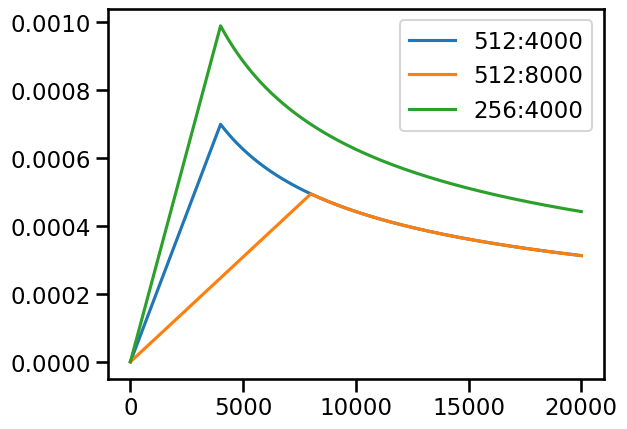

In [161]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

In [ ]:
class SimpleLossCompute:
    "a simple loss compute and train function"
    def __init__(self, generator, criterion, opt = None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(
            x.contiguous().view(-1, x.size(-1)),
            y.contiguous().view(-1))/norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm